In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import newton, brentq
from scipy.ndimage.filters import gaussian_filter1d
import pandas as pd

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
# Variáveis para o gráfico
plot_params = {'legend.fontsize': 30,
               'figure.figsize': (20, 10),
               'axes.labelsize':  30,
               'axes.titlesize':  30,
               'xtick.labelsize': 25,
               'ytick.labelsize': 25}

plt.style.use('ggplot')

plt.rcParams.update(plot_params)

color_dark_blue = [1/255, 62/255, 125/255]
color_light_blue = [6/255, 143/255, 203/255]
purple = [102/255, 51/255, 153/255]

color = [color_dark_blue, color_light_blue, purple]

# Modelo de Black-Scholes

O modelo de Black--Scholes para uma ativo $S$ supõe a seguinte dinâmica, sob a medida neutra ao risco,:
$$dS_{t} = r S_{t} dt + \sigma S_{t} dW^S_t,$$
onde $r$ e $\sigma$ são constantes e $W^S$ é um movimento Browniano. Uma simples aplicação da fórmula de Itô nos dá:
$$S_t = S_0 e^{(r - \sigma^2/2)t + \sigma W_t}.$$
Essa dinâmica é conhecida como movimento Browniano geométrico (GBM, em inglês).

In [16]:
def SimulateGBM(S0, T, r, sigma, N, M):
    '''
    Função que simula o preço do ativo subjacente no modelo de Black Scholes
    S0 (float > 0) - valor inicial do ativo subjacente
    T (float > 0) - maturidade (em anos)
    r (float) - taxa de juros livre de risco
    sigma (float > 0) - volatilidade
    N (int) - discretização do tempo
    M (int) - número de simulações para estimação por Monte Carlo
    ''' 
    time = np.linspace(0, T, N+1) # vetor dos tempos
    dt = time[1] - time[0]
    time_matrix = np.repeat(time, M).reshape(N+1,M) # vetor de tempos repetidos
    
    dW = np.sqrt(dt) * np.random.normal(size=(N,M))
    W = np.zeros((N+1,M))
    W[1:,:] = np.cumsum(dW, axis=0)

    paths = S0 * np.exp((r - sigma**2/2) * time_matrix + sigma * W)

    return paths

Text(0, 0.5, 'Preço do ativo')

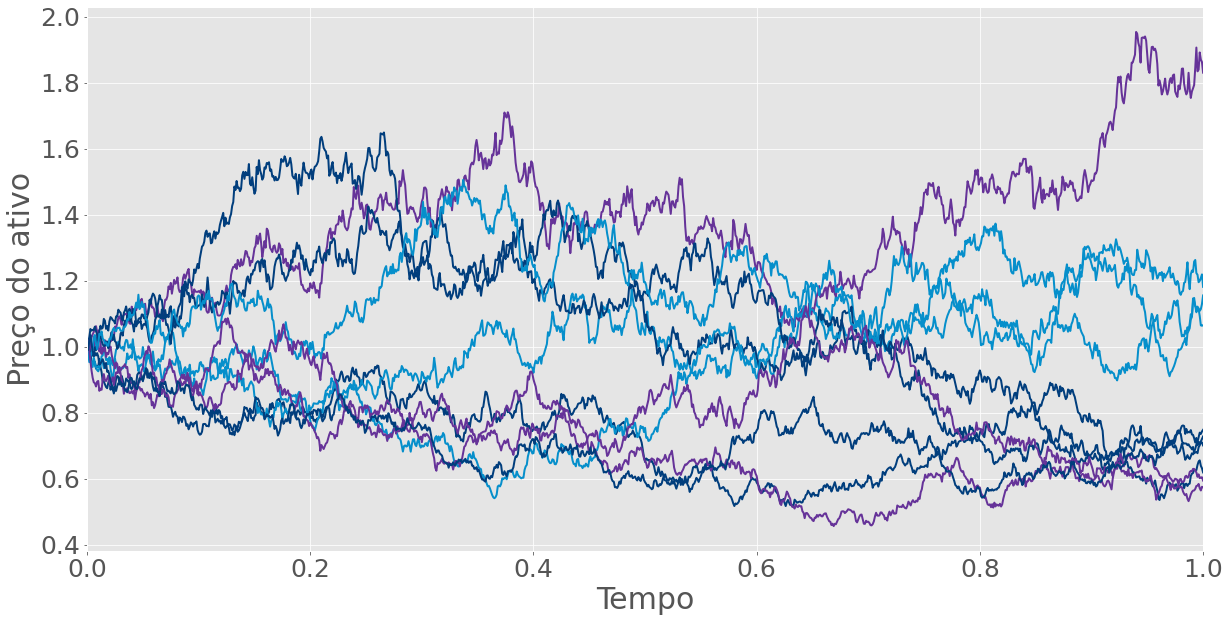

In [17]:
T = 1
S0 = 1
sigma = 0.5
r = 0.05

N = 1000 # discretização do tempo
M = 10 # número de simulações

S = SimulateGBM(S0, T, r, sigma, N, M)
colors = [color_dark_blue, color_light_blue, purple] * int((M/3 + 1))

plt.figure()
for i in range(M):
    plt.plot(np.linspace(0, T, N+1), S[:,i], linewidth=2, color=colors[i])
plt.xlim(0,T)
plt.xlabel('Tempo')
plt.ylabel('Preço do ativo')

Sob esse modelo, se denotarmos por $C^{BS}(t,S_{t},T,K,r,\sigma)$ o preço de uma call $(T,K)$ no instante $t$, pode-se mostrar que
\begin{align}\label{eq:formula_bs}
C^{BS}(t, S,T,K,r,\sigma) = S \Phi(d_{+}) - K e^{-r(T-t)}
\Phi(d_{-}),
\end{align}
onde $\Phi$ é a função de distribuição da normal padrão,
$$\Phi(d) = \int_{-\infty}^d \frac{e^{-x^2/2}}{\sqrt{2\pi}}dx,$$
$$d_{\pm} = 
\frac{\log\left(S/Ke^{-r(T-t)}\right)}{\sigma\sqrt{T-t}} \pm
 \frac{\sigma}{2}\sqrt{T-t}.$$
Essa  é a conhecida fórmula de Black--Scholes.

In [18]:
def BlackScholesFormula(S, T, K, sigma, r):
    '''
    Função que calcula o preço da call (T,K) no modelo Black-Scholes
    S0 (float > 0) - valor inicial do ativo subjacente
    T (float > 0) - maturidade (em anos)
    K (array > 0) - strikes
    sigma (float > 0) - volatilidade
    r (float) - taxa de juros livre de risco
    '''    
    d1 = (np.log(S/K) + (r + sigma**2/2)*T)/(sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    call_price = S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)
    
    return call_price

Text(0.5, 1.0, '$\\sigma$ - Volatilidade variando de 0.01 a 0.5')

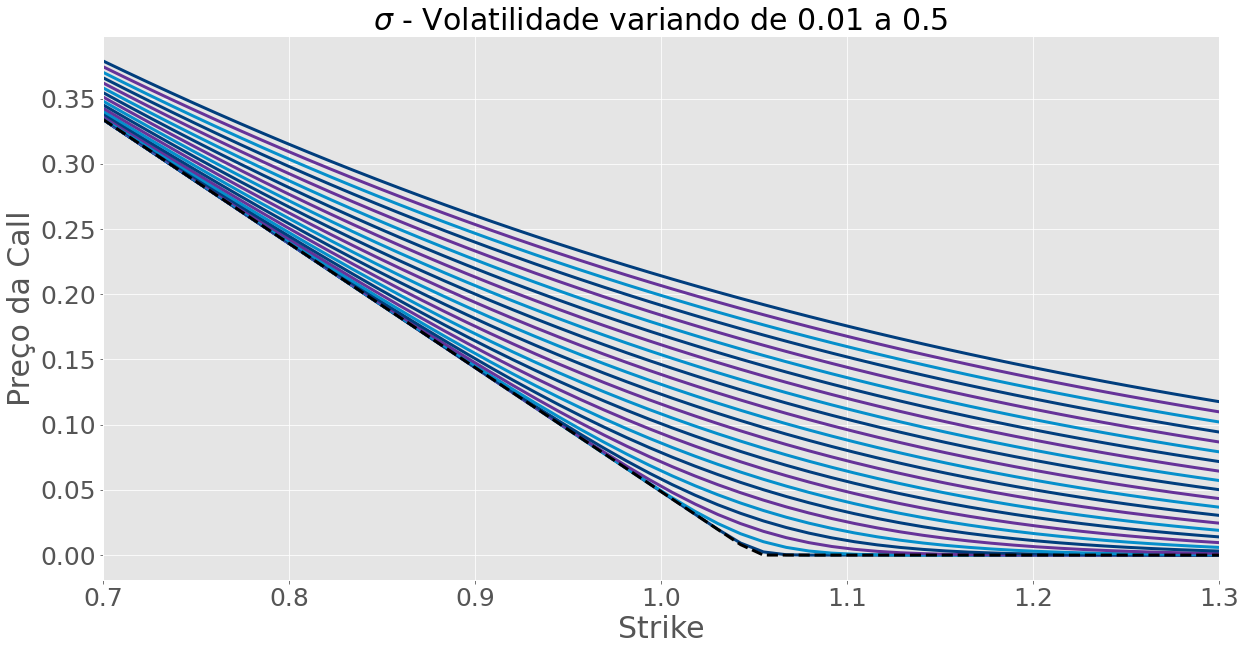

In [19]:
T = 1 #maturidade
S0 = 1 #valor inicial do ativo subjacente
K = S0 * np.linspace(0.7, 1.3, 50) #strikes
r = 0.05 # taxa de juros livre de risco

param_vary= np.arange(0.01,0.5,0.02) #variação dos parâmetros

colors = [color_dark_blue, color_light_blue, purple] * int((len(param_vary)/3 + 1))

call_prices_vary = []

for s in param_vary:

    call_prices = BlackScholesFormula(S0, T, K, s, r)

    call_prices_vary.append(call_prices)

plt.figure()    
for i in range(len(call_prices_vary)):
    plt.plot(K, call_prices_vary[i], linewidth=3 ,label=r'$\sigma  =  ' + str(param_vary[i]) + '$', color=colors[i])
plt.plot(K, np.maximum(S0 - np.exp(-r*T)*K, 0.0), linewidth=3, color='k', linestyle='dashed')
plt.xlabel('Strike')
plt.ylabel('Preço da Call')
plt.xlim(K[0], K[-1])
plt.title(r'$\sigma$ - Volatilidade variando de 0.01 a 0.5')

# Volatilidade Implícita

Seja $C_{t}(T,K)$ o preço (de mercado ou de um modelo) de uma call
$(T,K)$ no instante $t$. Definiremos a volatilidade implícita como sendo o número $\hat{\sigma}_{t}(T,K)$ que satisfaz
$$C_{t}(T,K) = C^{BS}(t,S_{t},T,K,r,\hat{\sigma}_{t}(T,K)).$$

Sabemos que, para $T, K$ e $0 \leq t \leq T$ fixos, se o preço $C_{t}(T,K) \in [(S_{t} - e^{-r(T-t)}K )^{+}, S_{t}]$, então a volatilidade implícita $\hat{\sigma}_{t}(T,K)$ existe e é única. De fato, $C^{BS} \in [(S_{t} - K e^{-r (T-t)})^{+},
S_{t}]$ e que $C^{BS}$ é estritamente crescente com respeito a $\sigma$.

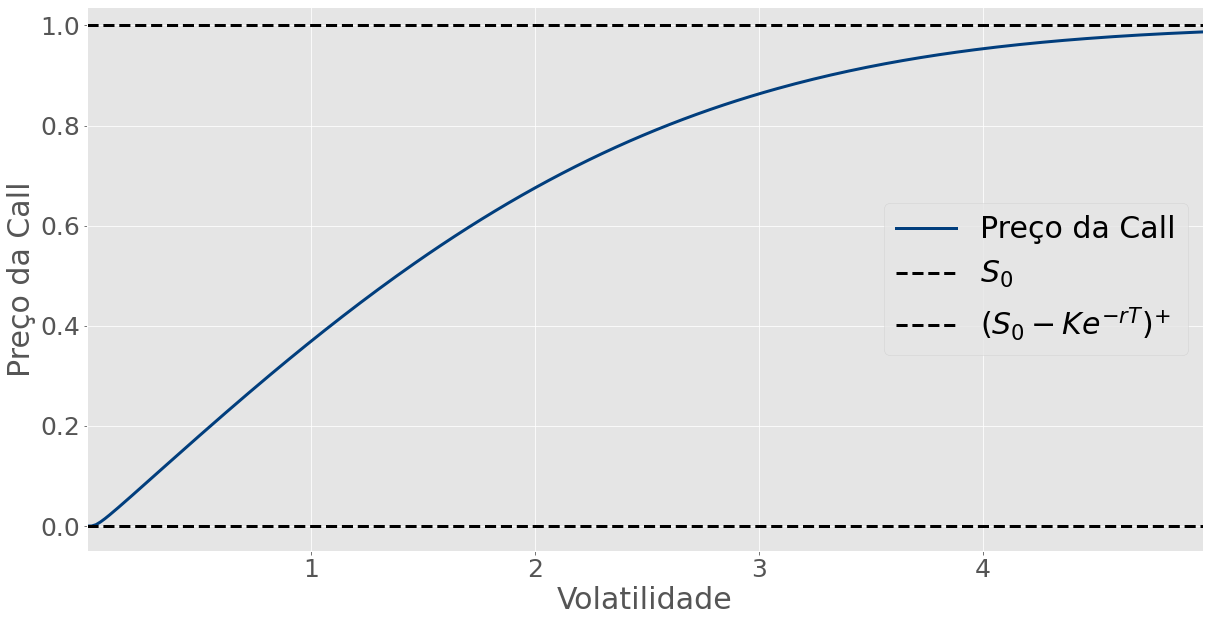

In [20]:
T = 1 #maturidade
S0 = 1 #valor inicial do ativo subjacente
K = 1.1
r = 0.05 # taxa de juros livre de risco

sigmas = np.arange(0.001,5.0,0.02)

call_prices = BlackScholesFormula(S0, T, K, sigmas, r)

plt.figure()    
plt.plot(sigmas, call_prices, linewidth=3 ,label='Preço da Call', color=color_dark_blue)
plt.xlabel('Volatilidade')
plt.ylabel('Preço da Call')
plt.axhline(S0, color='k', linestyle='dashed', linewidth=3, label=r'$S_0$')
plt.axhline(np.maximum(S0 - np.exp(-r*T)*K, 0.0), color='k', linestyle='dashed', linewidth=3, label=r'$(S_0 - K e^{-r T})^{+}$')
plt.xlim(sigmas[0], sigmas[-1])
plt.legend()

Calcular a volatilidade implícita de uma opção $(T,K)$ significa achar a raiz da equação
$$f(\sigma) = C^{BS}(t,S_{t},T,K,r,\sigma) - C_{t}(T,K),$$
onde $t, T, K, S_t$ e $r$ estão fixos. Existem diversos métodos numéricos para achar essa raiz, mas aqui especificaremos como o método de Newton funciona nesse caso. Dado um bom chute inicial $\sigma_0$, a seguinte iteração converge para $\hat{\sigma}_{t}(T,K)$:
$$\sigma_{n+1} = \sigma_n - \frac{f(\sigma_n)}{f'(\sigma_n)}.$$
Note que $f'$ é conhecida em fórmula fechada; de fato, é o Vega:
$$f'(\sigma) = \mbox{Vega}^{BS}(t,S_{t},T,K,r,\sigma) = S_t \phi(d_+) \sqrt{T-t},$$
onde $\phi$ é a densidade de probabilidade de uma normal padrão.

In [21]:
def BlackScholesVega(S, T, K, sigma, r):
    '''
    Função que calcula o Vega da call (T,K) no modelo Black-Scholes
    S0 (float > 0) - valor inicial do ativo subjacente
    T (float > 0) - maturidade (em anos)
    K (array > 0) - strikes
    sigma (float > 0) - volatilidade
    r (float) - taxa de juros livre de risco
    '''   
    
    d1 = (np.log(S/K) + (r + sigma**2/2)*T)/(sigma * np.sqrt(T))
    
    call_vega = S * norm.pdf(d1) * np.sqrt(T)
    
    return call_vega

def ImpliedVolatility(S, T, K, r, call_price, sigma0=0.2):
    '''
    Função que calcula a volatilidade implícita de uma call (T,K) no modelo Black-Scholes
    S0 (float > 0) - valor inicial do ativo subjacente
    T (float > 0) - maturidade (em anos)
    K (array > 0) - strikes
    r (float) - taxa de juros livre de risco
    call_price (float > 0) - preço da opção observada no mercado ou modelo
    sigma0 (float > 0, default=0.2) - chute inicial para a volatilidade implícita
    '''   
    
    func = lambda sigma: BlackScholesFormula(S, T, K, sigma, r) - call_price
    fprime = lambda sigma: BlackScholesVega(S, T, K, sigma, r)
    
    res = newton(func, x0=sigma0, fprime=fprime)
    #res = brentq(func, a=0.001, b=1.0)
    
    return res

# Exemplo com dados reais

O dado real a seguir é para opções no índice americano S&P 500 no dia 20 de Maio de 2020.

In [22]:
option_data = pd.read_excel('SPX_option_data.xlsx')

option_data = option_data[option_data.Open_Int > 0]
option_data = option_data[option_data.Vol > 0]
option_data = option_data[option_data.Bid > 0]
option_data['Moneyness'] = option_data['Strike']/option_data['Underlying_Price']
option_data[['Expiry','Quote_Time']] = option_data[['Expiry','Quote_Time']].apply(pd.to_datetime) 
option_data['Time to maturity'] = (option_data['Expiry'] - option_data['Quote_Time']).dt.days/360
# option_data = option_data[option_data['Time to maturity'] >= 0.1]
# option_data = option_data[option_data['Time to maturity'] <= 1.0]
option_data = option_data[option_data['Moneyness'] < 10]
option_data = option_data[option_data['Moneyness'] > 0.9]
option_data = option_data[option_data['Type'] == 'call']
option_data = option_data[option_data['Root'] == 'SPX']

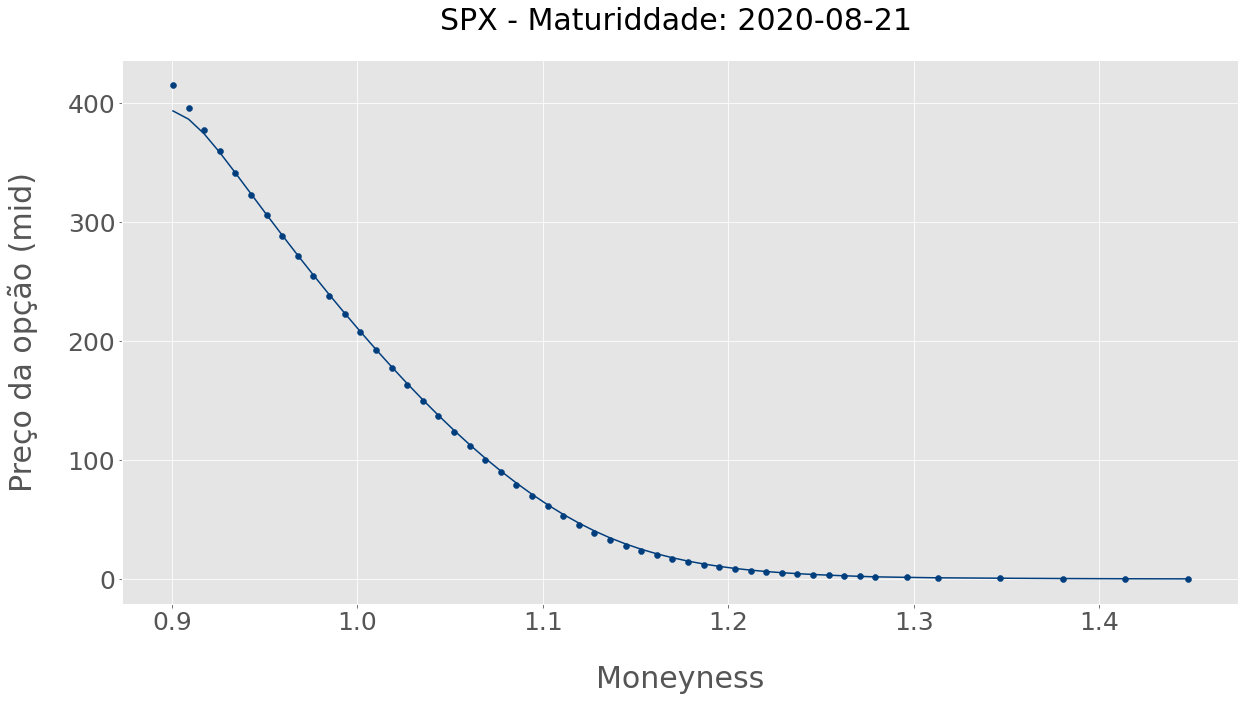

In [23]:
option_data_curve = option_data[option_data['Time to maturity'] >= 0.5]
option_data_curve = option_data_curve[option_data_curve['Time to maturity'] <= 0.57]

m = option_data_curve['Moneyness'].values

option_price = gaussian_filter1d(option_data_curve['Mid'].values, 2) #interpolação

fig, ax = plt.subplots(1,1)
plt.title('SPX - Maturiddade: ' + str(option_data['Expiry'].iloc[0])[:11], pad=30)
ax.plot(m,  option_price, c=color_dark_blue)
ax.scatter(m, option_data_curve['Mid'].values, c=[color_dark_blue])
ax.set_xlabel('Moneyness')
ax.set_ylabel('Preço da opção (mid)')
ax.yaxis.labelpad=30
ax.xaxis.labelpad=30

In [24]:
IV = np.zeros(len(m))
r = 0.0005
T = option_data_curve['Time to maturity'].values[0]
S0 = option_data_curve['Underlying_Price'].values[0]
K = option_data_curve['Strike'].values

IV[0] = ImpliedVolatility(S0, T, K[0], r, option_price[0], sigma0=0.3)

for i in range(1,len(K)):
    IV[i] = ImpliedVolatility(S0, T, K[i], r, option_price[i], sigma0=0.3)

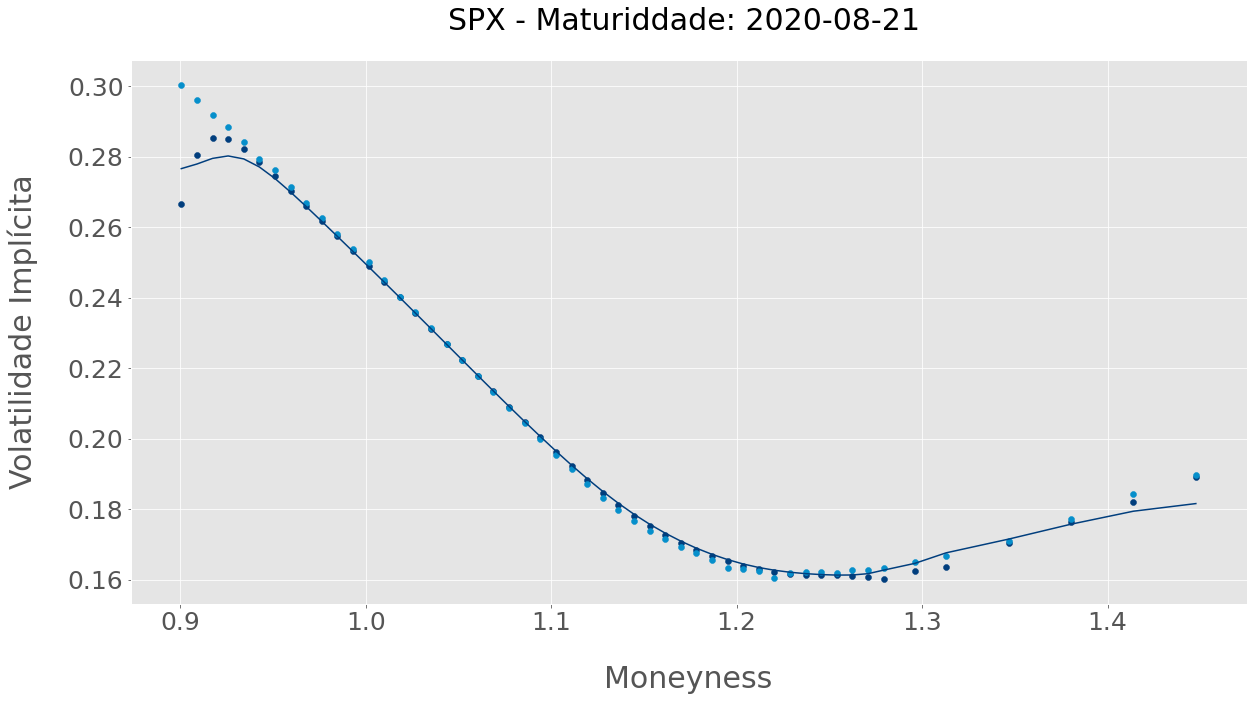

In [25]:
IV_filter = gaussian_filter1d(IV, 2)

fig, ax = plt.subplots(1,1)
plt.title('SPX - Maturiddade: ' + str(option_data['Expiry'].iloc[0])[:11], pad=30)
ax.plot(m,  IV_filter, c=color_dark_blue)
ax.scatter(m, IV, c=[color_dark_blue])
ax.scatter(m, option_data_curve['IV'].values, c=[color_light_blue])
ax.set_xlabel('Moneyness')
ax.set_ylabel('Volatilidade Implícita')
ax.yaxis.labelpad=30
ax.xaxis.labelpad=30

# Estimação dos Parâmetros

In [26]:
def EstimationParameters(S, dt):
    '''
    Função que calcula a estimativa do drift e vol supondo o modelo de BS
    S (array) - preço de ativo observado
    dt (float > 0) - tempo entre observações
    '''   
    log_return = np.diff(np.log(S), axis=0)

    sigma2_hat = np.var(log_return, axis=0, ddof=1)/dt

    mu_hat = np.mean(log_return, axis=0)/dt + 0.5 * sigma2_hat

    return sigma2_hat, mu_hat

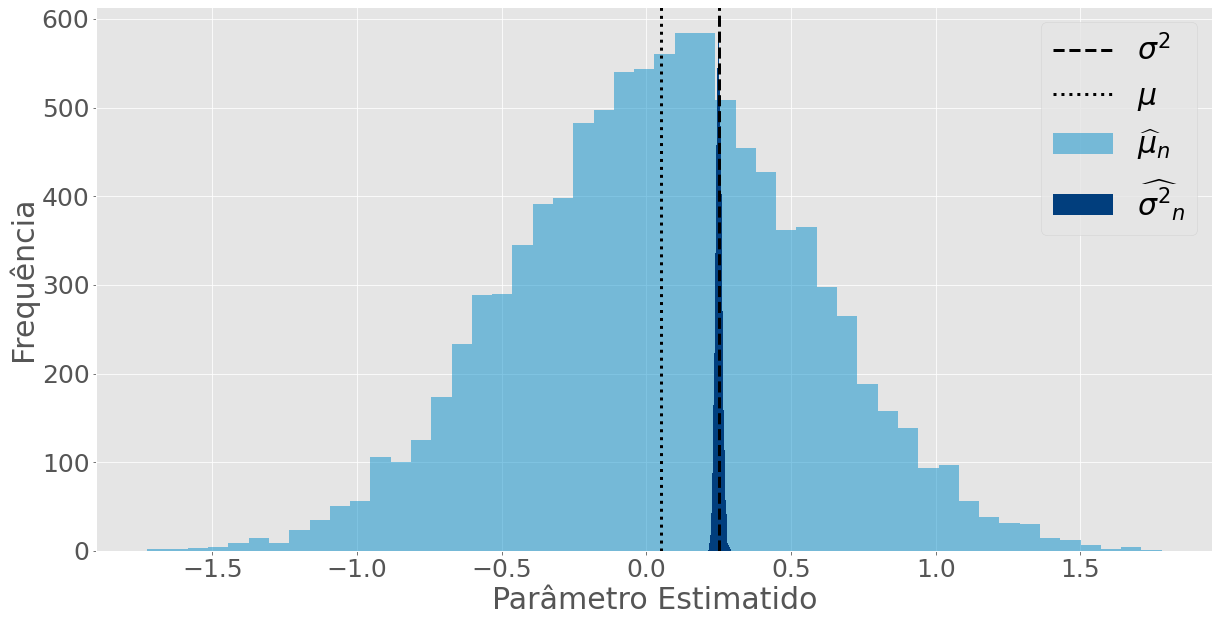

In [28]:
T = 1
S0 = 1
sigma = 0.5
mu = 0.05

N = 1000 # discretização do tempo
M = 10000 # número de simulações

time = np.linspace(0, T, N+1) # vetor com tempos
dt = time[1] - time[0]

S = SimulateGBM(S0, T, mu, sigma, N, M)

sigma2_hat, mu_hat = EstimationParameters(S, dt)

plt.figure()
plt.axvline(params['sigma']**2, color='k', linestyle='dashed', linewidth=3, label=r'$\sigma^2$')
plt.hist(mu_hat, bins=50, label=r'$\widehat{\mu}_n$', alpha=0.5, color=color_light_blue)
plt.axvline(mu, color='k', linestyle='dotted', linewidth=3, label=r'$\mu$')
plt.hist(sigma2_hat, bins=50, label=r'$\widehat{\sigma^2}_n$', color=color_dark_blue)
plt.ylabel('Frequência')
plt.xlabel('Parâmetro Estimatido')
plt.legend()